# Final Project

In [1]:
# Testing Cell
import os
os.getcwd()

'C:\\Users\\kaybean\\Documents\\UNC-Senior\\COMP562\\Final_Project\\Comp562-Final-Project'

![example](./data/Dataset_BUSI_with_GT_no_masks/benign/benign%20(1).png)

## Testing with our tumor data

In [6]:
# Packages
# import tensorflow as tf
# from tensorflow import keras
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

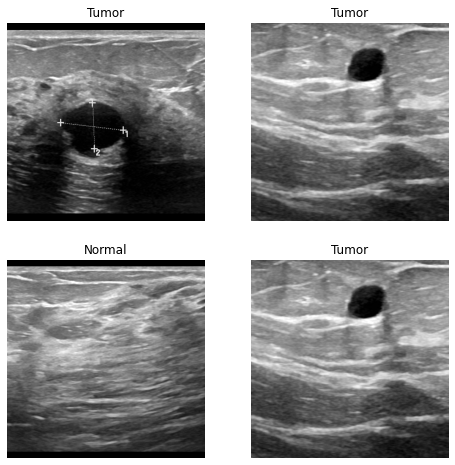

In [10]:
# Following https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2
# Get the data
data_dir = './data1'  # image directory

    # Here, we can add and extra convolutions/filters/etc of our own to the data
img_width = 500
img_height = 500
transform = transforms.Compose([transforms.CenterCrop((img_width, img_height)), transforms.Grayscale(), transforms.ToTensor()])  # crop all to same size, transform to tensors
dataset = datasets.ImageFolder(data_dir, transform=transform)  # load images

# Something is funky about their shape...


# print(dataset[0][0].size())

# Split into testing and training sets
num_samples = len(dataset)
num_test = int(0.1 * num_samples)  # ~10% 
# test_set = torch.utils.data.Subset(dataset, range(num_test))  # take first 10%
# train_set = torch.utils.data.Subset(dataset, range(num_test, num_samples))  # take the rest 
test_set, train_set = torch.utils.data.random_split(dataset, [num_test, num_samples-num_test])

# print(test_set[0])

# Extract images and labels
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)  # Split into batches
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)  # Split into batches
images, labels = next(iter(train_dataloader))

# What do the labels mean?
labels_map = {
    0: "Normal",
    1: "Tumor"
}
num_classes = 2

# Show a few samples
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img = np.transpose(images[sample_idx].numpy(), (1, 2, 0))
    lab = labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[lab])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([32, 1, 500, 500])
Labels batch shape: torch.Size([32])


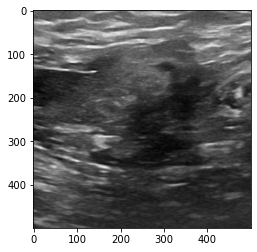

Label: 0 (Normal)


In [11]:
# Show the shape of the features and labels from each batch
# along with a sample from the batch
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = np.transpose(train_features[0].numpy(), (1, 2, 0)).squeeze()
label = train_labels[0].item()
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} ({labels_map[label]})")

In [12]:
print(train_set[1][1])

1


In [14]:
print("Overall:")
for k in labels_map.keys():
    print(labels_map[k], ":\t", dataset.targets.count(k), " - ", np.round(dataset.targets.count(k)/len(dataset)*100, 1), "%")

count = [0]*2
for i in range(len(train_set)):
    count[ train_set[i][1] ] += 1
    
print("Training:")
for k in labels_map.keys():
    print(labels_map[k], ":\t", count[k], " - ", np.round(count[k]/len(train_set)*100, 1), "%")

count = [0]*2
for i in range(len(test_set)):
    count[ test_set[i][1] ] += 1
    
print("Testing:")
for k in labels_map.keys():
    print(labels_map[k], ":\t", count[k], " - ", np.round(count[k]/len(test_set)*100, 1), "%")


Overall:
Normal :	 133  -  17.1 %
Tumor :	 647  -  82.9 %
Training:
Normal :	 125  -  17.8 %
Tumor :	 577  -  82.2 %
Testing:
Normal :	 8  -  10.3 %
Tumor :	 70  -  89.7 %


### Create a Neural Net

In [15]:
# Ensures use of hardware accelerator, like a gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Using {device} device')

Using cpu device


In [17]:
# Build a Neural Network to classify the MNISTFashion set
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(img_width*img_height, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=250000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


torch.Size([1, 500, 500])
Predicted class: Tumor


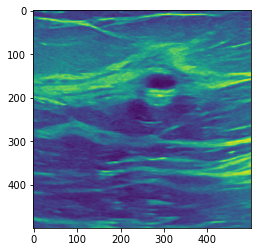

In [18]:
# Run the NN as is on random input
# X = torch.rand(3, 500, 500, device=device)
X = train_set[1][0]

# print(torch.equal(X[0], X[2]))
print(X.size())
plt.imshow(X.squeeze())

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {labels_map[y_pred.item()]}")

### Train the Model

In [20]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
# Functions to train and test the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
# Run a certain number of epochs for the training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.681074  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.359349 

Epoch 2
-------------------------------
loss: 0.544652  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.401595 

Epoch 3
-------------------------------
loss: 0.681735  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.382894 

Epoch 4
-------------------------------
loss: 0.432321  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.347991 

Epoch 5
-------------------------------
loss: 0.370709  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.361880 

Done!


### How does the model do?

In [26]:
# Calculate Accuracies
# from https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            if (i >= len(labels)): break
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(num_classes):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc} %')

Accuracy of the network: 89.74358974358974 %
Accuracy of Normal: 0.0 %
Accuracy of Tumor: 100.0 %


In [27]:
# Confusion Matrix from HW2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [28]:
model.eval()   # Make sure model is in eval mode

# Collect various pieces of data
pred_lab = np.array([])
pred_prob = np.array([])
test_labels = np.array([])

# Run the model over all test data
with torch.no_grad():
    for X, y in test_dataloader:
        pred = nn.Softmax(dim=1)(model(X))
        pred_lab = np.append(pred_lab, pred.argmax(1).tolist())
        pred_prob = np.append(pred_prob, [max(probs) for probs in pred.tolist()])
        test_labels = np.append(test_labels, y.tolist())
        
label_set = np.unique(test_labels)
label_names = np.array([labels_map[i] for i in label_set])

Confusion matrix, without normalization
[[ 0  8]
 [ 0 70]]


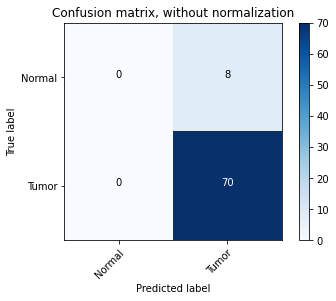

In [29]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, pred_lab)
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, label_names,
                      title='Confusion matrix, without normalization')

In [30]:
# Confusion Matrix with pictures from HW2
import matplotlib.image as mpimg
def gen_err_predicted_fig( data, test_labels, pred_lab, pred_prob, label_set, label_names, figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_prob[errIdx] )
                    errFIdx = errIdx[ np.argmax( pred_prob[errIdx] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    num = len(label_set)
    for i in range(num*num):
        rIdx = i // num
        cIdx = i % num
        ax = plt.subplot(num, num, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])], 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])],  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]    
            plt.imshow(data[fIdx][0].squeeze())
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
        
#         if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
#             fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
#             folderName = label_names[test_labels[fIdx]]            
#             fID = test_sample_ids[fIdx]
#             img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + \
#                              fID.decode('utf-8') + '.jpg')    
#             plt.imshow(img)  # The AxesGrid object work as a list of axes.
#         else:
#             plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
#                      **title_font)
    
    plt.show()

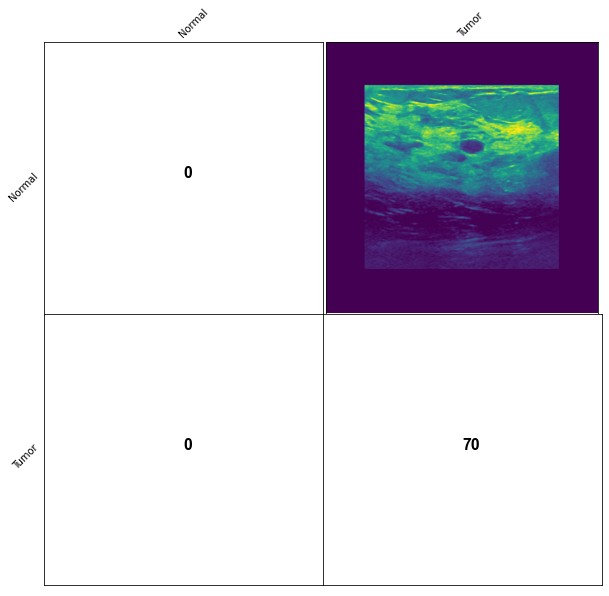

In [31]:
gen_err_predicted_fig( test_set, test_labels, pred_lab, pred_prob, label_set, label_names)

### Try a CNN

torch.Size([1, 1, 500, 500])
torch.Size([1, 6, 496, 496])
torch.Size([1, 6, 248, 248])
torch.Size([1, 16, 244, 244])
torch.Size([1, 16, 122, 122])


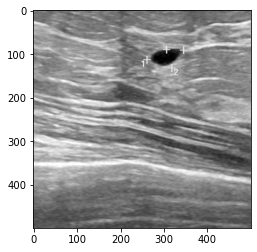

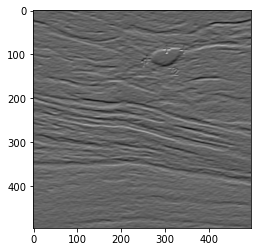

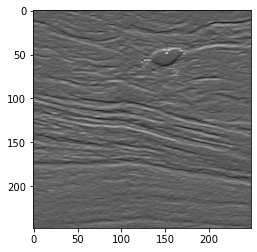

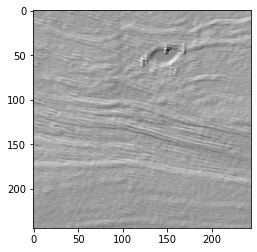

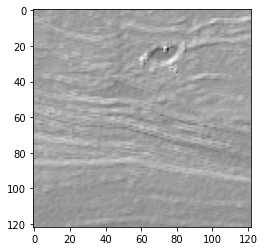

In [32]:
# Playing around with convolutions and pooling

# Datapoint
sample_idx = torch.randint(len(dataset), size=(1,)).item()
x = dataset[sample_idx][0]
plt.figure()
plt.imshow(x.squeeze(), cmap="gray")
print(x.unsqueeze(0).size())

# Layers
conv1 = nn.Conv2d(1, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

with torch.no_grad():
    x = conv1(x.unsqueeze(0))
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())
    
    x = pool(x)
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())
    
    x = conv2(x)
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())
    
    x = pool(x)
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())


In [33]:
# Parameters for CNN
# size = (x+2p-w)/s + 1

conv1params = [1, 6, 11, 4, 0]
conv2params = [conv1params[1], 20, 5, 1, 2]
conv3params = [conv2params[1], 40, 3, 1, 1]
poolparams  = [-1, -6, 3, 2, 0]

layers = [conv1params, poolparams, conv2params, poolparams, conv3params, poolparams]

# k1 = 11
# s1 = 4
# p1 = 0
# k2 = 5
# s2 = 1
# p2 = 2
# k3 = 3
# s3 = 1
# p3 = 1
# kp = 3
# sp = 2
# pp = 0

def getSize(x, k, s, p):
    return int(np.floor((x+2*p-k)/s) + 1)

w = img_width
h = img_height
for layer in layers:
    w = getSize(w, *layer[2:])
    h = getSize(h, *layer[2:])

In [34]:
# Build a Convolutional Neural Network to classify the MNISTFashion set
# adapted from https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

import torch.nn.functional as F
print(conv3params[1] * w * h)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(*conv1params)   # 1 color channel, output channel size, kernel size, stride 
        
        self.pool = nn.MaxPool2d(*poolparams[2:4])    # kernel size 3, stride 2
        
        self.conv2 = nn.Conv2d(*conv2params)
        self.conv3 = nn.Conv2d(*conv3params)
        
#         self.conv4 = nn.Conv2d(1, 6, 11, 4, 0)
        
        self.fc1 = nn.Linear(conv3params[1] * w * h , 256)
#         self.fc2 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = self.pool(F.relu(self.conv3(x)))  
#         print(x.size())
        x = x.view(-1, conv3params[1] * w * h)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = self.fc2(x)               # -> n, 84
#         x = self.fc3(x)                       # -> n, 10
        return x
    
model = ConvNet().to(device)
print(model)

7840
ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(11, 11), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7840, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


torch.Size([1, 500, 500])
tensor([[0.0782, 0.0285]], grad_fn=<AddmmBackward0>)
Predicted class: Normal


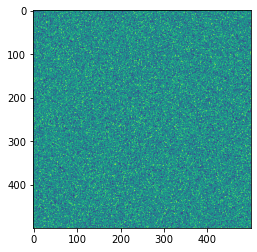

In [35]:
# Run the NN as is on random input
X = torch.rand(1, img_width, img_height, device=device)
# X = train_set[1][0]

# print(torch.equal(X[0], X[2]))
print(X.size())
plt.imshow(X.squeeze())

logits = model(X.unsqueeze(0))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(logits)
print(f"Predicted class: {labels_map[y_pred.item()]}")

### Train the Model

In [36]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [37]:
# Functions to train and test the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [38]:
# Run a certain number of epochs for the training
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.709592  [    0/  702]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.690009 

Epoch 2
-------------------------------
loss: 0.690446  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.666436 

Epoch 3
-------------------------------
loss: 0.668558  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.646846 

Epoch 4
-------------------------------
loss: 0.668378  [    0/  702]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.626347 

Done!


### Visualizing Layers

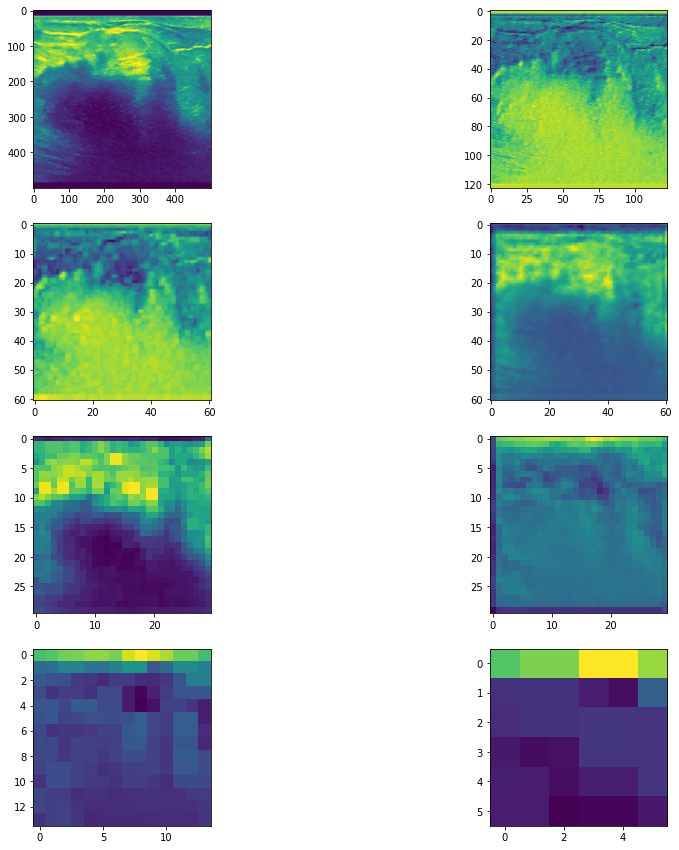

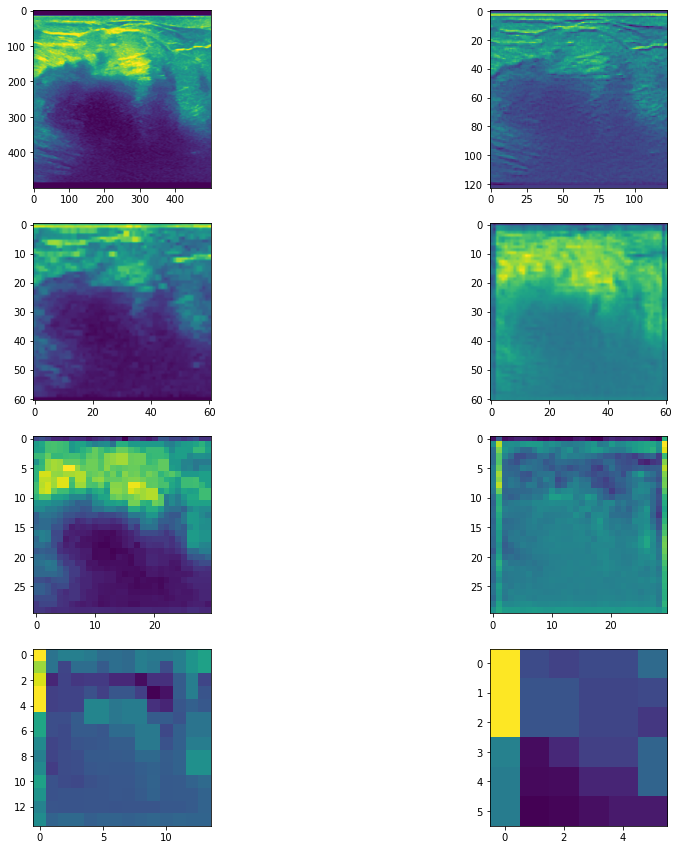

In [39]:
# Datapoint
sample_idx = torch.randint(len(dataset), size=(1,)).item()
x_og = dataset[sample_idx][0]

rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
axs[0,0].imshow(x_og.squeeze())
x = x_og.unsqueeze(0)

# print(x.unsqueeze(0).size())

layers = [0, model.conv1, model.pool, model.conv2, model.pool, model.conv3, model.pool, model.pool]

with torch.no_grad():
    for r in range(rows):
        for c in range(cols):
            if (r == 0 and c == 0): continue
            idx = r*cols + c
            x = layers[idx](x)
            axs[r,c].imshow(x.squeeze()[0])
            
    fig, axs = plt.subplots(rows, cols, figsize=(15,15))
    axs[0,0].imshow(x_og.squeeze())
    x = x_og.unsqueeze(0)
    for r in range(rows):
        for c in range(cols):
            if (r == 0 and c == 0): continue
            idx = r*cols + c
            x = layers[idx](x)
            axs[r,c].imshow(x.squeeze()[1])
    
#     x = model.conv1(x.unsqueeze(0))
# #     plt.figure()
#     axs[1].imshow(x.squeeze()[0], cmap="gray")
#     print(x.size())
    
#     x = model.pool(x)
# #     plt.figure()
#     plt.imshow(x.squeeze()[0], cmap="gray")
#     print(x.size())

### How does the model do?

In [40]:
# Calculate Accuracies
# from https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            if (i >= len(labels)): break
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(num_classes):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc} %')

Accuracy of the network: 89.74358974358974 %
Accuracy of Normal: 0.0 %
Accuracy of Tumor: 100.0 %


In [41]:
# Confusion Matrix from HW2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [42]:
model.eval()   # Make sure model is in eval mode

# Collect various pieces of data
pred_lab = np.array([])
pred_prob = np.array([])
test_labels = np.array([])

# Run the model over all test data
with torch.no_grad():
    for X, y in test_dataloader:
        pred = nn.Softmax(dim=1)(model(X))
        pred_lab = np.append(pred_lab, pred.argmax(1).tolist())
        pred_prob = np.append(pred_prob, [max(probs) for probs in pred.tolist()])
        test_labels = np.append(test_labels, y.tolist())
        
label_set = np.unique(test_labels)
label_names = np.array([labels_map[i] for i in label_set])

Confusion matrix, without normalization
[[ 0  8]
 [ 0 70]]


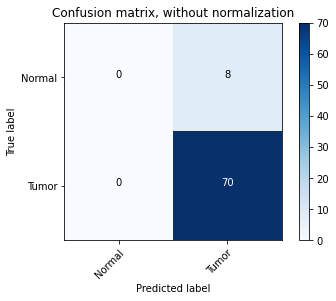

In [43]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, pred_lab)
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, label_names,
                      title='Confusion matrix, without normalization')

In [44]:
# Confusion Matrix with pictures from HW2
import matplotlib.image as mpimg
def gen_err_predicted_fig( data, test_labels, pred_lab, pred_prob, label_set, label_names, figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_prob[errIdx] )
                    errFIdx = errIdx[ np.argmax( pred_prob[errIdx] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    num = len(label_set)
    for i in range(num*num):
        rIdx = i // num
        cIdx = i % num
        ax = plt.subplot(num, num, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])], 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])],  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]    
            plt.imshow(data[fIdx][0].squeeze())
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
        
#         if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
#             fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
#             folderName = label_names[test_labels[fIdx]]            
#             fID = test_sample_ids[fIdx]
#             img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + \
#                              fID.decode('utf-8') + '.jpg')    
#             plt.imshow(img)  # The AxesGrid object work as a list of axes.
#         else:
#             plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
#                      **title_font)
    
    plt.show()

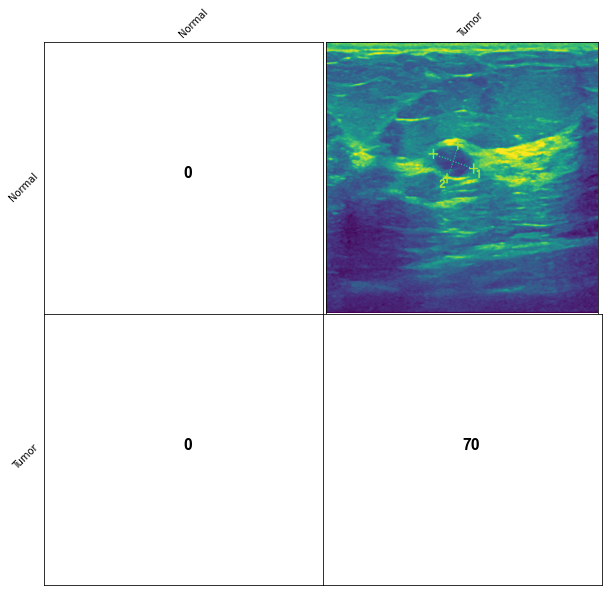

In [45]:
gen_err_predicted_fig( test_set, test_labels, pred_lab, pred_prob, label_set, label_names)